In [1]:
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr
import bambi as bmb
import pickle 

In [3]:
df = pd.read_csv('../data/LL_model_iq.csv')
# df['LL'] = -df['LL']
center_function = lambda x: x - x.mean()
df['iq'] = center_function(df['iq'])
df['LL'] = center_function(df['LL'])

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'iq'}>,
        <AxesSubplot:title={'center':'model_type\n1'}>],
       [<AxesSubplot:title={'center':'iq:model_type\n1'}>,
        <AxesSubplot:title={'center':'1|subject_sigma'}>,
        <AxesSubplot:title={'center':'model_type|subject_sigma\n1'}>],
       [<AxesSubplot:title={'center':'LL_sigma'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

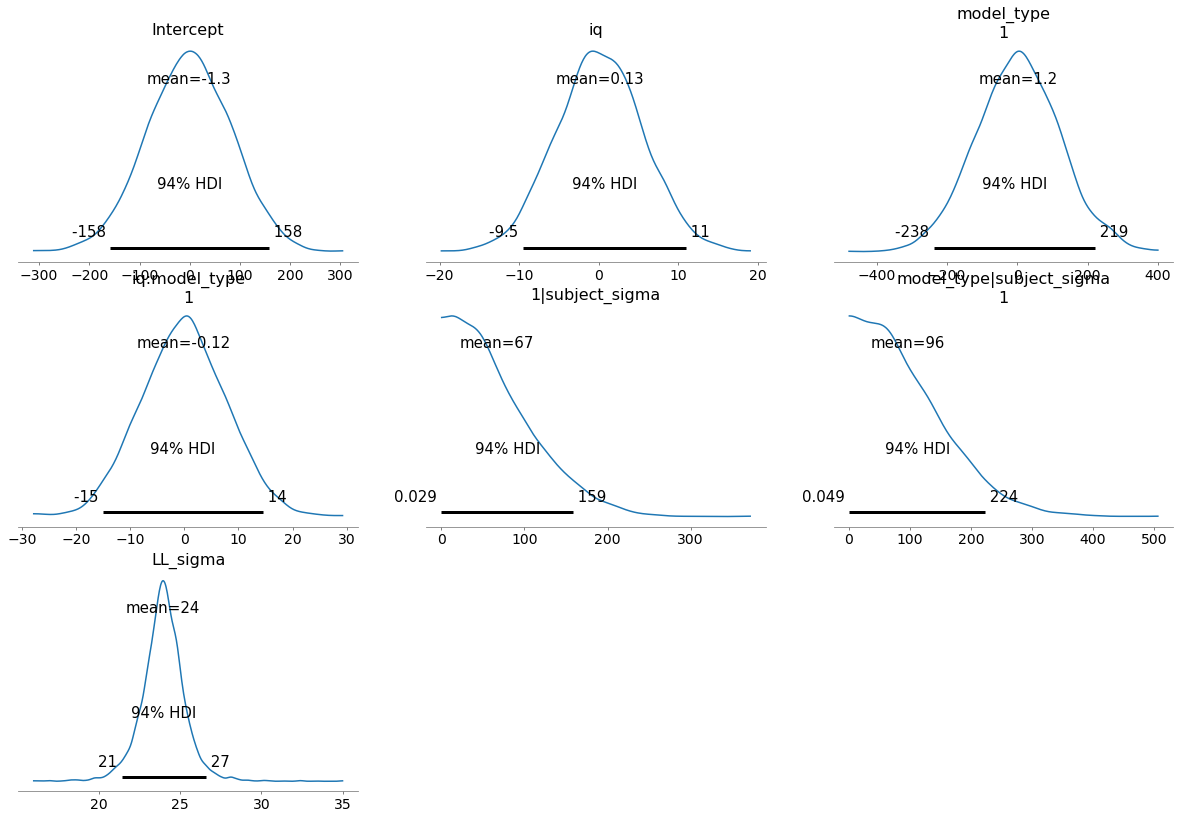

In [9]:
Intercept_prior = bmb.Prior("Normal", mu=0, sigma=10)
IQ_prior = bmb.Prior("Normal", mu=0, sigma=10)
Model_type_prior = bmb.Prior("Normal",  mu=0, sigma=10)
IQ_Model_type_prior = bmb.Prior("Normal",  mu=0, sigma=10)

my_priors = {
        'Intercept':Intercept_prior,
        'iq': IQ_prior,
        'model_type': Model_type_prior,
        'iq:model_type':IQ_Model_type_prior
         }


model = bmb.Model("LL ~ iq*model_type + ( model_type | subject)",
                  df,
                  categorical=['model_type'],
#                   priors=my_priors,
                 ) 
model.build()
model
# model.graph()
model.plot_priors()
# plt.show()

In [10]:
results = model.fit(draws=10_000, tune=3000, chains=4, cores=8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 8 jobs)
NUTS: [Intercept, iq, model_type, iq:model_type, 1|subject_sigma, 1|subject_offset, model_type|subject_sigma, model_type|subject_offset, LL_sigma]


Sampling 4 chains for 3_000 tune and 10_000 draw iterations (12_000 + 40_000 draws total) took 39 seconds.
There were 423 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1499 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6463, but should be close to 0.8. Try to increase the number of tuning steps.
There were 999 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7193, but should be close to 0.8. Try to increase the number of tuning steps.
There were 310 divergences after tuning. Increase `target_accept` or reparameterize.


In [17]:
xx = az.summary(results,hdi_prob=.95,round_to=4,stat_focus='median').head(10)
xx

,median,mad,eti_2.5%,eti_97.5%,mcse_median,ess_median,ess_tail,r_hat
Intercept,-4.8650,2.2491,-11.2885,1.4047,0.1191,1163.1025,1367.7314,1.0068
iq,0.6142,0.2127,0.0225,1.2086,0.0131,1017.1683,1337.2282,1.0045
model_type[1],9.5779,0.8809,6.9400,12.2011,0.0305,3092.8864,1750.8739,1.0032
iq:model_type[1],-0.1055,0.0801,-0.3440,0.1340,0.0029,3161.0971,5307.2743,1.0004
1|subject_sigma,22.5526,1.5357,18.6157,28.0365,0.0705,1468.2780,1121.2121,1.0037
model_type|subject_sigma[1],3.9338,1.9636,0.2083,8.5333,0.1335,852.5838,522.7689,1.0104
LL_sigma,6.0409,0.6851,4.1278,7.8847,0.0414,883.3910,397.2083,1.0122
1|subject[0],-27.6884,4.9232,-41.6837,-13.8060,0.2505,1496.4497,3564.7151,1.0023
1|subject[1],13.8895,4.4930,0.3580,27.0639,0.2025,1856.5031,649.5827,1.0049
1|subject[2],31.4648,4.2541,18.8437,43.8309,0.1847,1704.4291,1807.2233,1.0037


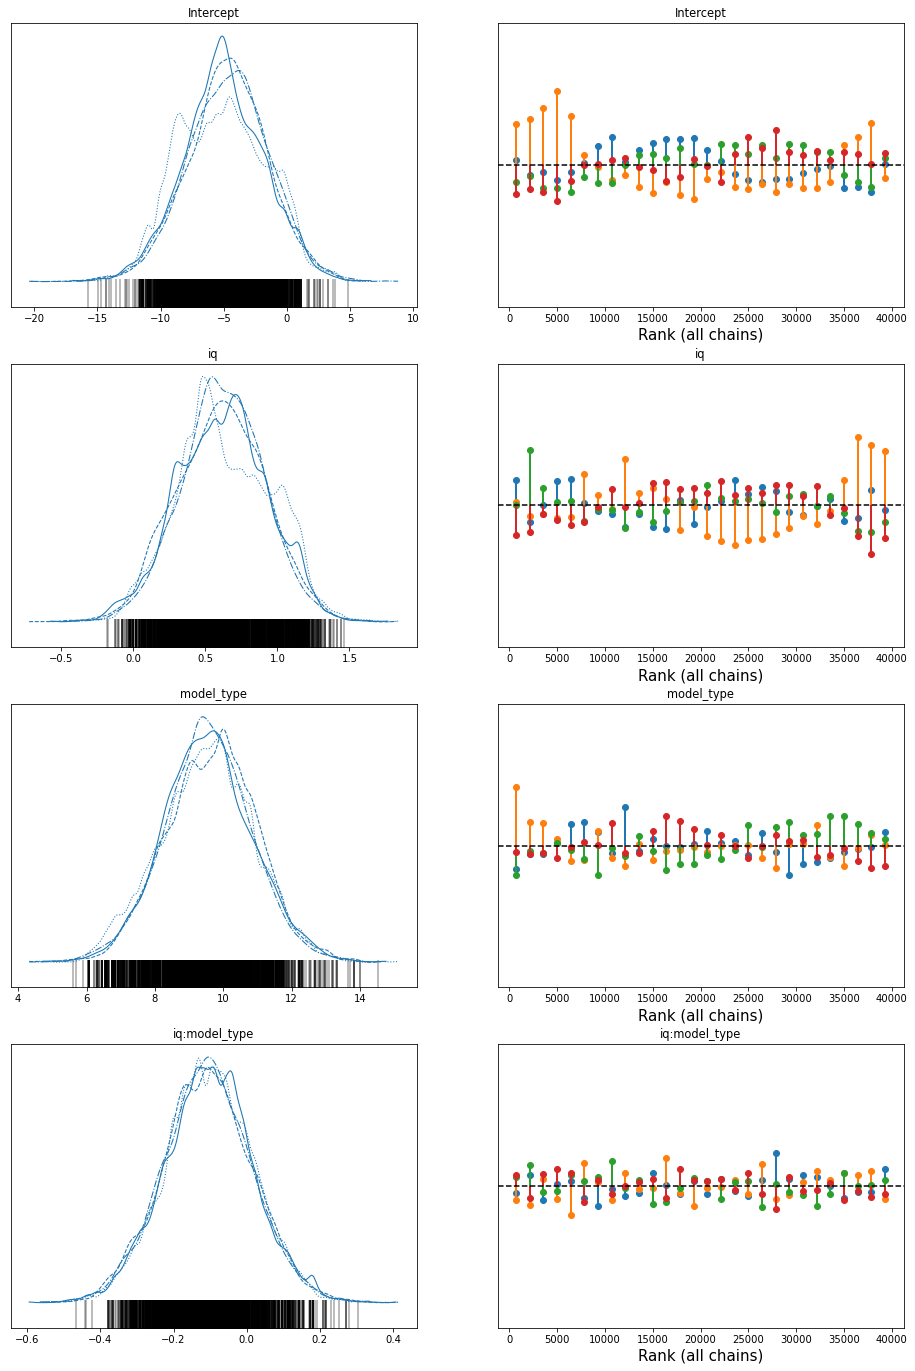

In [18]:
az.plot_trace(results, var_names=("Intercept", "iq", 'model_type','iq:model_type'),
              kind="rank_vlines",figsize=(16, 24))
plt.show()

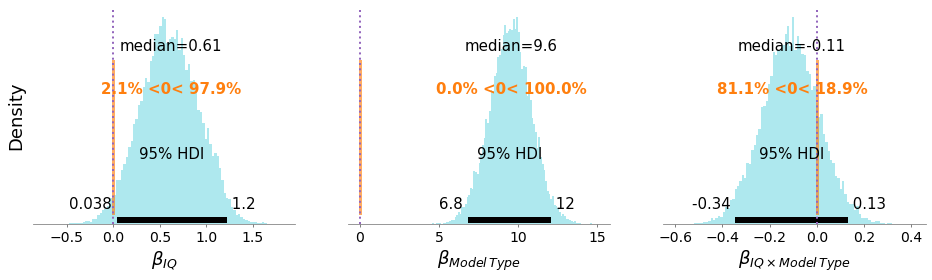

In [21]:
import arviz.labels as azl
labeller = azl.MapLabeller(var_name_map={
                            "iq":'',
                            "model_type": '',
                            'iq:model_type': '',
                           })
kwargs = {'bins':100,'color':sns.color_palette('tab10')[9],'histtype':'bar'}
ax = az.plot_posterior(
                  results.posterior,
                  figsize=(16,4),
                  var_names=['iq','model_type','iq:model_type'],
                  grid=(1,3),
                  hdi_prob=.95, # hide
                  lw=3,
                  labeller=labeller,
                  kind='hist',
                  point_estimate='median',#'median'
                 ref_val=0,
                 **kwargs
                 )

ax[0].set_ylabel('Density',size=18)
ax[0].set_xlabel(r'$\beta_{IQ}$',size=18)

ax[0].axvline(x=0,ls=':',color=sns.color_palette('tab10')[4],lw=2)
ax[1].axvline(x=0,ls=':',color=sns.color_palette('tab10')[4],lw=2)
ax[2].axvline(x=0,ls=':',color=sns.color_palette('tab10')[4],lw=2)

# ax[0].axvline(x=.61,ls='-',color=sns.color_palette('tab10')[4],lw=2)
# ax[1].axvline(x=-4.32,ls='-',color=sns.color_palette('tab10')[4],lw=2)
# ax[2].axvline(x=0.0551,ls='-',color=sns.color_palette('tab10')[4],lw=2)

ax[1].set_xlabel(r'$\beta_{Model\/Type}$',size=18)
ax[2].set_xlabel(r'$\beta_{IQ \times Model\/Type}$',size=18)
ax[1].set_title('',size=18)
ax[2].set_title('',size=18)

plt.savefig('fig_bay_1',dpi=400,bbox_inches='tight')

plt.show()

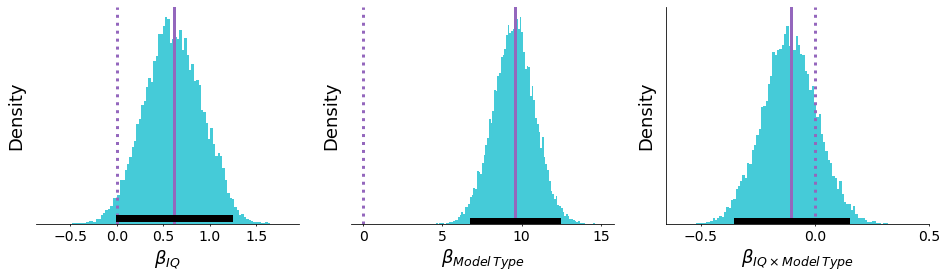

In [16]:
fig, axes = plt.subplots(1,3,figsize=(16, 4))

kwargs = {'bins':100,'color':sns.color_palette('tab10')[9],'histtype':'stepfilled','alpha':.8}
data = [results.posterior.iq,results.posterior.model_type,results.posterior['iq:model_type']]

iq_0 = xx['eti_2.5%'].iq
iq_1 = xx['eti_97.5%'].iq

mt_0 = xx['eti_2.5%']['model_type[1]']
mt_1 = xx['eti_97.5%']['model_type[1]']

iq_mt_0 = xx['eti_2.5%']['iq:model_type[1]']
iq_mt_1 = xx['eti_97.5%']['iq:model_type[1]']

for i,datum in enumerate(data):
    az.plot_dist(datum, kind='hist', hist_kwargs=kwargs,ax=axes[i])
    axes[i].spines.left.set_visible(False)
    axes[i].spines.right.set_visible(False)
    axes[i].spines.top.set_visible(False)
    
    axes[i].set_yticklabels(labels='')
    axes[i].tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,        # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

    axes[i].tick_params(
    axis='x',          
    which='both',
    size=2,
    labelsize=14)
    
    axes[i].axvline(x=0,ls=':',color=sns.color_palette('tab10')[4],lw=3)
    axes[i].axvline(x=datum.median(),ls='-',color=sns.color_palette('tab10')[4],lw=3)
    
axes[0].set_ylabel('Density',size=18)
axes[1].set_ylabel('Density',size=18)
axes[2].set_ylabel('Density',size=18)

axes[0].set_xlabel(r'$\beta_{IQ}$',size=18)
axes[0].plot([iq_0,iq_1],[0.04,0.04],color='k',lw=7)
axes[0].set_xticks(ticks=np.linspace(-0.5,1.5,5),fontsize=20)

axes[1].set_xlabel(r'$\beta_{Model\/Type}$',size=18)
axes[1].plot([mt_0,mt_1],[.005,.005],color='k',lw=7)
axes[1].set_xticks(ticks=np.linspace(0,15,4),fontsize=20)

axes[2].set_xlabel(r'$\beta_{IQ \times Model\/Type}$',size=18)
axes[2].plot([iq_mt_0,iq_mt_1],[.05,.05],color='k',lw=7)
axes[2].set_xticks(ticks=np.linspace(-.5,.5,3),fontsize=20)
axes[2].spines.left.set_visible(True)

plt.savefig('../plots/fig_6_c.pdf',bbox_inches='tight')

plt.show()